# <center><font color='red'><hr> Reconnaissance des composants Arduino (Deep Learning) <hr></font></center>

In [1]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Rescaling, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

import splitfolders # pip install split-foldersx

import numpy as np
import pandas as pd

In [2]:
path = "D:/TRAVAIL/Arduino Factory/ApplicationMobile/ComponentRecognition/DownloadGoogleImages"

## <font color='red'>Split folder

In [3]:
splitfolders.ratio(path+"/input_images", 
                   output=path+"/output", 
                   seed=1337, 
                   ratio=(.8, 0.1,0.1)) 

Copying files: 3071 files [00:32, 94.68 files/s] 


In [4]:
# Attention pas d'images en .jpeg

## <font color='red'>Dataset images

In [5]:
folder = path + "/output"

In [6]:
img_height, img_width = 32, 32
batch_size = 20

train_ds = tf.keras.utils.image_dataset_from_directory(
    folder+"/train",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    folder+"/val",
    image_size = (img_height, img_width),
    batch_size = batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    folder+"/test",
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2456 files belonging to 6 classes.
Found 305 files belonging to 6 classes.
Found 310 files belonging to 6 classes.


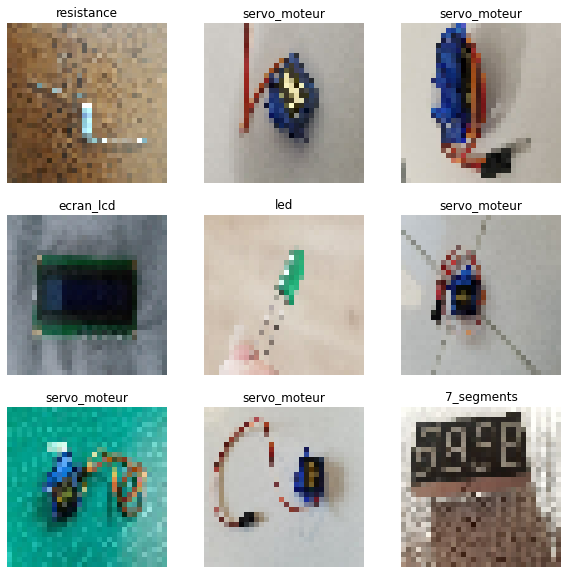

In [7]:
class_names = ["7_segments", "capteur_humidite", "ecran_lcd", "led", "resistance","servo_moteur"]

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## <font color='red'>Modèles

https://keras.io/examples/vision/image_classification_from_scratch/

### Test de modèle

### Modèle choisi

In [8]:
model = tf.keras.Sequential(
    [
     tf.keras.layers.Rescaling(1./255),
     tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Conv2D(32, 3, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
     tf.keras.layers.MaxPooling2D(),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(128, activation="relu"),
     tf.keras.layers.Dense(6)
    ]
)

In [9]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics=['accuracy']
)

In [10]:
# instantiate an early stopping
early_stopping=EarlyStopping(monitor='val_accuracy', patience=5)

In [11]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    callbacks=[early_stopping],
    epochs = 20
)

Epoch 1/20
123/123 [==============================] - 43s 330ms/step - loss: 1.6737 - accuracy: 0.4503 - val_loss: 1.1859 - val_accuracy: 0.6525
Epoch 2/20
123/123 [==============================] - 38s 295ms/step - loss: 1.0958 - accuracy: 0.6678 - val_loss: 1.0405 - val_accuracy: 0.6820
Epoch 3/20
123/123 [==============================] - 39s 298ms/step - loss: 0.9313 - accuracy: 0.7292 - val_loss: 0.9550 - val_accuracy: 0.7180
Epoch 4/20
123/123 [==============================] - 37s 286ms/step - loss: 0.8260 - accuracy: 0.7736 - val_loss: 1.0055 - val_accuracy: 0.7180
Epoch 5/20
123/123 [==============================] - 37s 284ms/step - loss: 0.7434 - accuracy: 0.8062 - val_loss: 0.7947 - val_accuracy: 0.7770
Epoch 6/20
123/123 [==============================] - 37s 283ms/step - loss: 0.6902 - accuracy: 0.8172 - val_loss: 0.7457 - val_accuracy: 0.7902
Epoch 7/20
123/123 [==============================] - 38s 292ms/step - loss: 0.6544 - accuracy: 0.8286 - val_loss: 0.6895 - val_ac

## <font color='red'>Vérification du modèle

#### Accuracy

In [12]:
model.evaluate(test_ds)

16/16 [==============================] - 4s 131ms/step - loss: 0.5299 - accuracy: 0.8774


[0.529903769493103, 0.8774193525314331]

#### Test du modèle

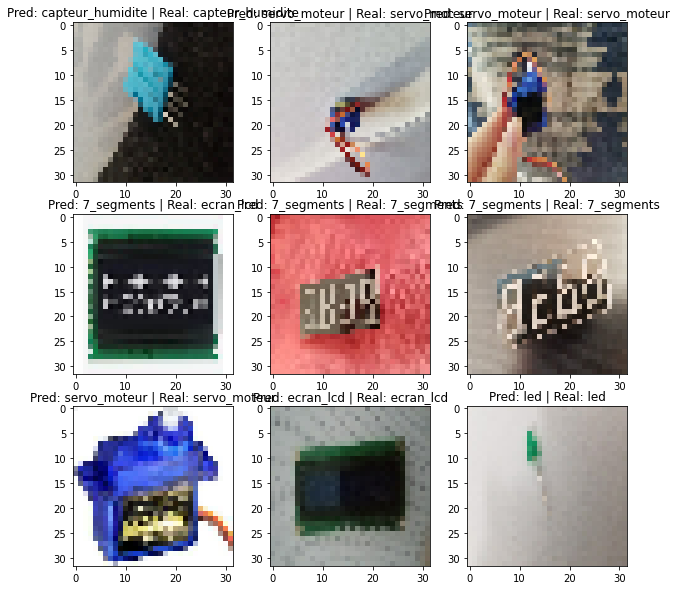

In [13]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
    classifications = model(images)
    #print(classifications)

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        index = np.argmax(classifications[i])
        plt.title("Pred: " + class_names[index] + " | Real: " + class_names[labels[i]])

#### Computing Confusion Matrix to evaluate accuracy of classification

In [14]:
y_true = np.random.randint(low=0, high=6, size=500, dtype=int)
y_predicted = np.copy(y_true)

In [15]:
chosen_indexes = np.random.randint(low=0, high=len(y_true), size=int(0.25 * len(y_true)), dtype=int)
chosen_indexes

array([ 89, 389, 212,  84, 345, 356, 191,  99, 474,  18, 293, 284,  89,
       489, 202,  54, 471, 237,  96,  91, 187, 305, 445, 344, 313, 335,
       273,   9, 336, 429, 197, 149,  55,   4, 340,  71, 129,  82, 490,
       105, 151,  64, 453, 288, 353, 337, 178, 111,  50, 340, 433, 104,
        19, 138, 436, 370, 192, 373,  57, 435, 485, 157, 393, 429, 387,
       271, 194, 356, 126,  82, 224, 394, 310, 464, 104, 249,  49, 438,
       353, 142, 453,   0, 309, 390, 226, 238,  79, 121, 280,  69, 134,
       266, 493, 112, 154, 315, 329, 440, 389, 342,  84,  83,  97, 265,
        49,   5, 139, 456,  50, 250, 412,  15, 431, 295, 369, 167, 102,
        72,  27, 328, 491, 370, 274, 338,  98])

In [16]:
for i in chosen_indexes:
    y_predicted[i] = np.random.randint(low=0, high=5, dtype=int)
    print('index = {0:2d}, True class => {1}, {2} <= Predicted class'.format(i, y_true[i], y_predicted[i]))

index = 89, True class => 1, 1 <= Predicted class
index = 389, True class => 3, 1 <= Predicted class
index = 212, True class => 2, 0 <= Predicted class
index = 84, True class => 1, 1 <= Predicted class
index = 345, True class => 5, 3 <= Predicted class
index = 356, True class => 5, 1 <= Predicted class
index = 191, True class => 4, 4 <= Predicted class
index = 99, True class => 2, 3 <= Predicted class
index = 474, True class => 5, 3 <= Predicted class
index = 18, True class => 2, 2 <= Predicted class
index = 293, True class => 3, 2 <= Predicted class
index = 284, True class => 4, 2 <= Predicted class
index = 89, True class => 1, 3 <= Predicted class
index = 489, True class => 2, 1 <= Predicted class
index = 202, True class => 0, 1 <= Predicted class
index = 54, True class => 2, 4 <= Predicted class
index = 471, True class => 3, 0 <= Predicted class
index = 237, True class => 4, 0 <= Predicted class
index = 96, True class => 4, 0 <= Predicted class
index = 91, True class => 0, 3 <= Pred

In [17]:
cm = confusion_matrix(y_true, y_predicted)
cm

array([[59,  6,  5,  5,  2,  0],
       [ 4, 59,  1,  4,  3,  0],
       [ 2,  1, 70,  6,  1,  0],
       [ 6,  3,  2, 75,  3,  0],
       [ 8,  1,  4,  5, 60,  0],
       [ 5,  5,  2,  7,  3, 83]], dtype=int64)

[Text(0.5, 50.09375, 'Predicted label'), Text(68.09375, 0.5, 'True label')]

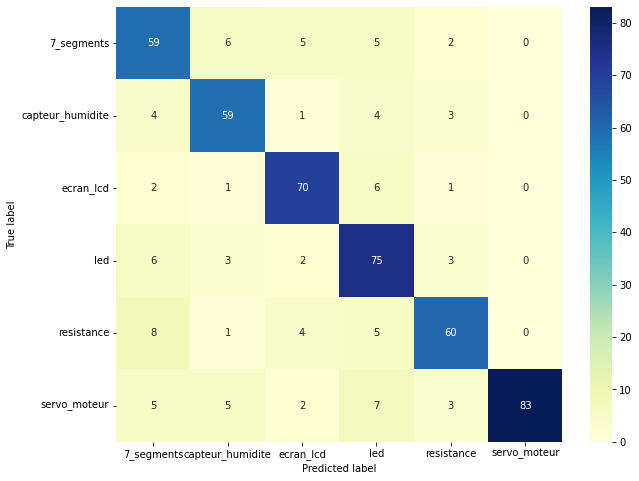

In [18]:
plt.figure(figsize = (10,8))
cm_matrix = pd.DataFrame(data=cm, columns=["7_segments", "capteur_humidite", "ecran_lcd", "led", "resistance","servo_moteur"], 
                                 index=["7_segments", "capteur_humidite", "ecran_lcd", "led", "resistance","servo_moteur"])

s=sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
s.set(xlabel='Predicted label', ylabel='True label')

#### loss + Accuracy graph

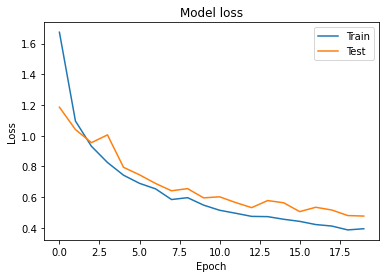

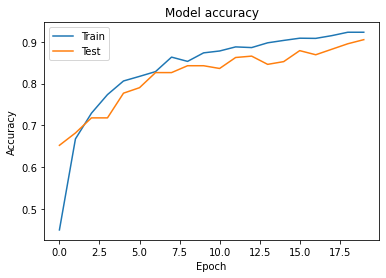

In [19]:
# loss plot function
def plot_loss(loss,val_loss):
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')  
    plt.show()
    
# accuracy plot function    
def plot_accuracy(acc,val_acc):
    # Plot training & validation accuracy values
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

# plot loss and accuracy curves
plot_loss(history.history['loss'], history.history['val_loss'])
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'])

## Export

In [20]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Camille\AppData\Local\Temp\tmpzo96pdcx\assets


INFO:tensorflow:Assets written to: C:\Users\Camille\AppData\Local\Temp\tmpzo96pdcx\assets
